In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 1e-6 # erodibility
beta = 0.0005 # abradability
r = 10. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.5 # fraction plucked that becomes coarse

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 10
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * I
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * gamma)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - (Eb_p[:-1]*gamma) - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 8000000

test_run = [x, dx, x_node, 
            K, beta, gamma,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

80000000.0


In [7]:
Eb

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 0.e+00])

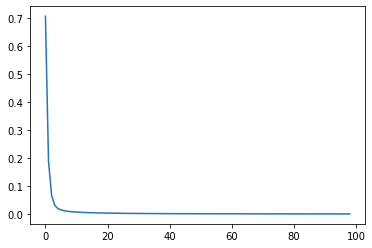

In [8]:
plt.plot(S)

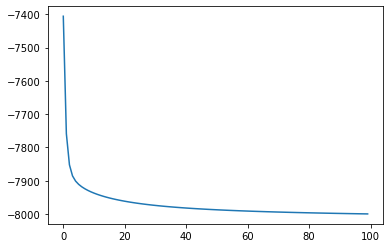

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.0002926246504921437

In [11]:
eta

array([-7406.08326763, -7758.69517861, -7852.04811401, -7885.27225505,
       -7900.84034799, -7910.65403685, -7917.94872794, -7923.84114334,
       -7928.82558253, -7933.16246145, -7937.00669524, -7940.45893563,
       -7943.58905748, -7946.44810707, -7949.07489427, -7951.49987477,
       -7953.74756253, -7955.83809836, -7957.78831009, -7959.61245336,
       -7961.3227447 , -7962.92975497, -7964.44270651, -7965.8697019 ,
       -7967.21790336, -7968.49367547, -7969.70270053, -7970.85007267,
       -7971.9403757 , -7972.97774802, -7973.96593721, -7974.90834632,
       -7975.80807345, -7976.66794566, -7977.49054834, -7978.27825068,
       -7979.03322789, -7979.75748068, -7980.45285237, -7981.12104399,
       -7981.76362769, -7982.3820586 , -7982.97768541, -7983.55175983,
       -7984.10544503, -7984.63982324, -7985.15590256, -7985.65462312,
       -7986.13686261, -7986.60344132, -7987.05512664, -7987.49263723,
       -7987.91664674, -7988.32778723, -7988.72665228, -7989.11379982,
      

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([5.93316734e+02, 2.40704823e+02, 1.47351887e+02, 1.14127746e+02,
       9.85596532e+01, 8.87459643e+01, 8.14512732e+01, 7.55588578e+01,
       7.05744186e+01, 6.62375397e+01, 6.23933059e+01, 5.89410655e+01,
       5.58109437e+01, 5.29518941e+01, 5.03251069e+01, 4.79001264e+01,
       4.56524386e+01, 4.35619028e+01, 4.16116911e+01, 3.97875478e+01,
       3.80772565e+01, 3.64702462e+01, 3.49572947e+01, 3.35302993e+01,
       3.21820978e+01, 3.09063257e+01, 2.96973006e+01, 2.85499285e+01,
       2.74596255e+01, 2.64222531e+01, 2.54340640e+01, 2.44916549e+01,
       2.35919277e+01, 2.27320555e+01, 2.19094528e+01, 2.11217505e+01,
       2.03667733e+01, 1.96425205e+01, 1.89471488e+01, 1.82789572e+01,
       1.76363735e+01, 1.70179426e+01, 1.64223158e+01, 1.58482413e+01,
       1.52945561e+01, 1.47601779e+01, 1.42440986e+01, 1.37453781e+01,
       1.32631386e+01, 1.27965599e+01, 1.23448745e+01, 1.19073639e+01,
       1.14833544e+01, 1.10722139e+01, 1.06733489e+01, 1.02862014e+01,
      

In [14]:
# save csv files

np.savetxt('elevation csv files/eta_exp_8.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_exp_8.csv', alpha, delimiter = ',')
np.savetxt('slope csv files/slope_exp_8.csv', S, delimiter = ',')

In [15]:
# calc width

b = (kb * Q[1:] * S**(7/6)) / (D**(3/2))

np.savetxt('width csv files/b_exp_8.csv', b, delimiter = ',')
np.savetxt('Qs csv files/Qs_exp_8.csv', Qs, delimiter = ',')